# Personal Information
Name: Robin van den Berg

StudentID: 11317345

Email: [**robin.vanden.berg@student.uva.nl**](robin.vanden.berg@student.uva.nl)

Submitted on: 15-03-2023

# Data Context
**In this section you should introduce the datasources and datasets which you will be working with. Explain where they are from as well as their domain. Give an overview of what the context of the data is. You should not spend more than 1 to 2 paragraphs here as the core information will be in the next section.**

The data presented in this EDA is from Elsevier and is named Canary. The dataset is a subset of the Embase database. The Embase database is a biomedical research database maintained by the published Elsevier. The datbase is indexed by Emtree indexing terms, Elsevier’s authoritative life science thesaurus. The dataset contains the abstracts, keywords, titles and some supplemental information about articles present in this database in combination with the Emtree terms that are linked in to articles.

In this project, the Emtree terms are the labels that we want to assign to the papers. The Emtree terms are polyhierarchical, meaning that we have multiple tree structures that link the terms, while terms can still occur in two (or more) hierarchies at the same time. The Emtree terms index the entire text and pose a multilabel classification problem where the labels are not independent.

# Data Description

**Present here the results of your exploratory data analysis. Note that there is no need to have a "story line" - it is more important that you show your understanding of the data and the methods that you will be using in your experiments (i.e. your methodology).**

**As an example, you could show data, label, or group balances, skewness, and basic characterizations of the data. Information about data frequency and distributions as well as results from reduction mechanisms such as PCA could be useful. Furthermore, indicate outliers and how/why you are taking them out of your samples, if you do so.**

**The idea is, that you conduct this analysis to a) understand the data better but b) also to verify the shapes of the distributions and whether they meet the assumptions of the methods that you will attempt to use. Finally, make good use of images, diagrams, and tables to showcase what information you have extracted from your data.**

As you can see, you are in a jupyter notebook environment here. This means that you should focus little on writing text and more on actually exploring your data. If you need to, you can use the amsmath environment in-line: $e=mc^2$ or also in separate equations such as here:

\begin{equation}
    e=mc^2 \mathrm{\space where \space} e,m,c\in \mathbb{R}
\end{equation}

Furthermore, you can insert images such as your data aggregation diagrams like this:

![image](example.png)

In [43]:
# Imports
import ast
import os
import sys
import itertools
from itertools import combinations
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [44]:
sys.path.append(
  os.path.abspath(os.path.join(os.path.dirname('data_loader.py'), os.path.pardir)))
from src.data.data_loader import DataLoader

In [45]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Data Loading

In [46]:
loc_dict = {
    'train': '../data/raw/canary/set_B_train_kw.csv',
    'val': '../data/raw/canary/set_B_val_kw.csv',
    'test': '../data/raw/canary/set_B_test_kw.csv',
    'xml':  '../data/raw/canary/original_xml_files/20210210_11422_194_1.xml',
    'xml_csv':  '../data/raw/canary/original_xml_files/all_articles_diff_labels.csv'
}
data_loader = DataLoader(loc_dict)

In [47]:
data_df = data_loader.load_xml_csv()


### Analysis 1: 
Explore content of the data. What is in there, and what are the mistakes.

Side note: The data was originally structured as separate XML files. This files have subsequently been parsed to csv, extracting the information that is likely to be useful and that we want to use for the research.

In [48]:
# what does the data look like?
print(f"The shape of the data: {data_df.shape}")
print(f"The columns that we have for each article: \n {data_df.columns.tolist()}")
print(f"A sample of the data:")
data_df.head()

The shape of the data: (121369, 65)
The columns that we have for each article: 
 ['file_name', 'pui', 'title', 'keywords', 'abstract', 'abstract_2', 'authors', 'organization', 'chemicals', 'num_refs', 'date-delivered', 'labels_m', 'labels_a', 'human', 'mouse', 'rat', 'nonhuman', 'controlled study', 'animal experiment', 'animal tissue', 'animal model', 'animal cell', 'major clinical study', 'clinical article', 'case report', 'multicenter study', 'systematic review', 'meta analysis', 'observational study', 'pilot study', 'longitudinal study', 'retrospective study', 'case control study', 'cohort analysis', 'cross-sectional study', 'diagnostic test accuracy study', 'double blind procedure', 'crossover procedure', 'single blind procedure', 'adult', 'aged', 'middle aged', 'child', 'adolescent', 'young adult', 'very elderly', 'infant', 'school child', 'newborn', 'preschool child', 'embryo', 'fetus', 'male', 'female', 'human cell', 'human tissue', 'normal human', 'human experiment', 'phase 2 c

,file_name,pui,title,keywords,abstract,abstract_2,authors,organization,chemicals,num_refs,date-delivered,labels_m,labels_a,human,mouse,rat,nonhuman,controlled study,animal experiment,animal tissue,animal model,animal cell,major clinical study,clinical article,case report,multicenter study,systematic review,meta analysis,observational study,pilot study,longitudinal study,retrospective study,case control study,cohort analysis,cross-sectional study,diagnostic test accuracy study,double blind procedure,crossover procedure,single blind procedure,adult,aged,middle aged,child,adolescent,young adult,very elderly,infant,school child,newborn,preschool child,embryo,fetus,male,female,human cell,human tissue,normal human,human experiment,phase 2 clinical trial,randomized controlled trial,clinical trial,controlled clinical trial,phase 3 clinical trial,phase 1 clinical trial,phase 4 clinical trial
0,../data/raw/canary/original_xml_files\20210210...,624531411,Genetic influence on cognitive development bet...,NaN,Successful cognitive development between child...,NaN,"[{'initials': 'J.', 'indexed-name': 'Mollon J....","[{'organization_country': 'usa', 'organization...",NaN,66.0,2021-02-10,"adolescent,adult,child,cohort analysis,female,...","adolescent,adult,child,cohort analysis,control...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
1,../data/raw/canary/original_xml_files\20210210...,625340088,Central amygdala circuit dynamics underlying t...,NaN,Benzodiazepines (BZDs) have been a standard tr...,NaN,"[{'initials': 'J.', 'indexed-name': 'Griessner...","[{'organization_country': 'aut', 'organization...",benzodiazepine diazepam,39.0,2021-02-10,"animal cell,animal experiment,animal tissue,co...",human,0,1,0,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,../data/raw/canary/original_xml_files\20210210...,625805682,Genetic variants in the bipolar disorder risk ...,NaN,Bipolar disorder (BD) is a common mood disorde...,NaN,"[{'initials': 'M.', 'indexed-name': 'Rathje M....","[{'organization_country': 'usa', 'organization...",NaN,73.0,2021-02-10,"animal cell,animal tissue,controlled study,hum...","adult,controlled study,human",1,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,../data/raw/canary/original_xml_files\20210210...,626513810,Think twice before submitting your precious ar...,Journal article|Journalism|Medical journalism|...,NaN,NaN,"[{'initials': 'I.', 'indexed-name': 'Coskun Be...","[{'organization_country': 'tur', 'organization...",NaN,NaN,2021-02-10,human,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,../data/raw/canary/original_xml_files\20210210...,626662493,Polyphenolic content and bioactivities of Crat...,antimicrobial activity|antioxidant activity|Cr...,Solid-Liquid Extraction (SLE) using solvent of...,NaN,"[{'initials': 'W.', 'indexed-name': 'Benabderr...","[{'organization_country': 'dza', 'organization...",acetic acid ethyl ester caffeic acid epicatech...,8.0,2021-02-10,nonhuman,nonhuman,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [49]:
# check the missing data for each column
percent_missing = data_df.isnull().sum() * 100 / len(data_df)

print(percent_missing)

file_name                          0.000000
pui                                0.000000
title                              0.000000
keywords                          18.167736
abstract                           3.343523
abstract_2                        99.032702
authors                            0.000000
organization                       0.000000
chemicals                         39.180516
num_refs                           0.632781
date-delivered                     0.000000
labels_m                           4.290222
labels_a                           3.336931
human                              0.000000
mouse                              0.000000
rat                                0.000000
nonhuman                           0.000000
controlled study                   0.000000
animal experiment                  0.000000
animal tissue                      0.000000
animal model                       0.000000
animal cell                        0.000000
major clinical study            

In [50]:
# see structure of author and organisation information
data_df['authors'] = data_df['authors'].apply(lambda x: ast.literal_eval(x))
data_df['organization'] = data_df['organization'].apply(lambda x: ast.literal_eval(x))

### Visualise the structure of the labels

In [51]:
label_structure_df = pd.read_csv('../data/raw/canary/original_xml_files/paulas_labels.csv', sep=';')

In [52]:
label_structure_df

,human,0,organism studied
0,mouse,0,organism studied
1,rat,0,organism studied
2,nonhuman,0,organism studied
3,controlled study,1,controlled study
4,animal experiment,2,animal study type
5,animal tissue,2,animal study type
6,animal model,2,animal study type
7,animal cell,2,animal study type
8,major clinical study,3,human study type (clinical work)
9,clinical article,3,human study type (clinical work)


### Evaluate the occurrence and the co-occurrence of the different labels 


In [53]:
def get_labels(row):
    """De-onehot encode a row."""
    return(list(row.index[row==1]))

In [54]:
# get all labels in separate dataframe
label_columns = data_df.loc[:, ~data_df.columns.isin(['file_name', 'pui', 'title', 'keywords', 'abstract', 'abstract_2', 'authors', 'organization', 'chemicals', 'num_refs', 'date-delivered', 'labels_m', 'labels_a'])]
label_columns = label_columns.astype(int)

<Axes: >

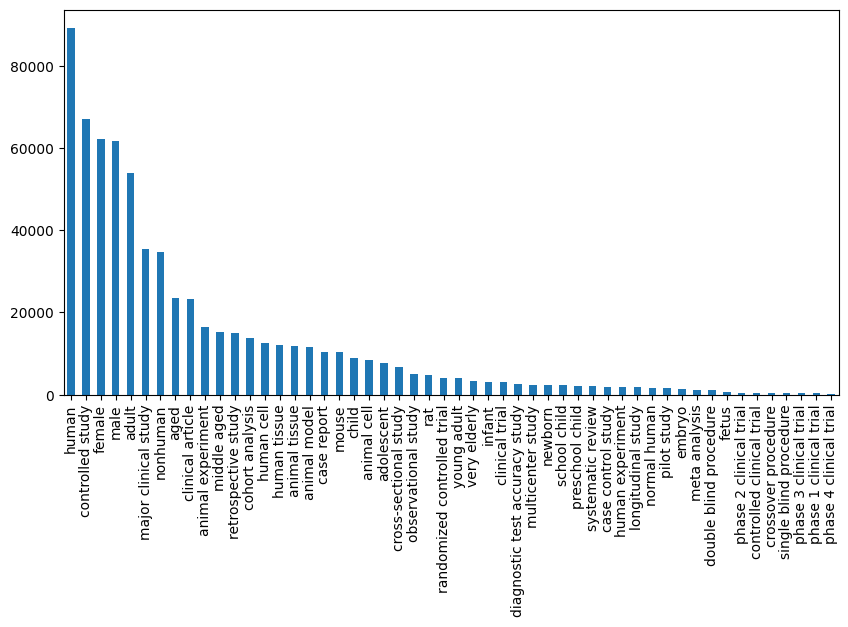

In [55]:
label_occurrences = label_columns.sum().sort_values(ascending=False)
plt.figure(figsize = (10,5))
label_occurrences.plot(kind='bar')

<Axes: >

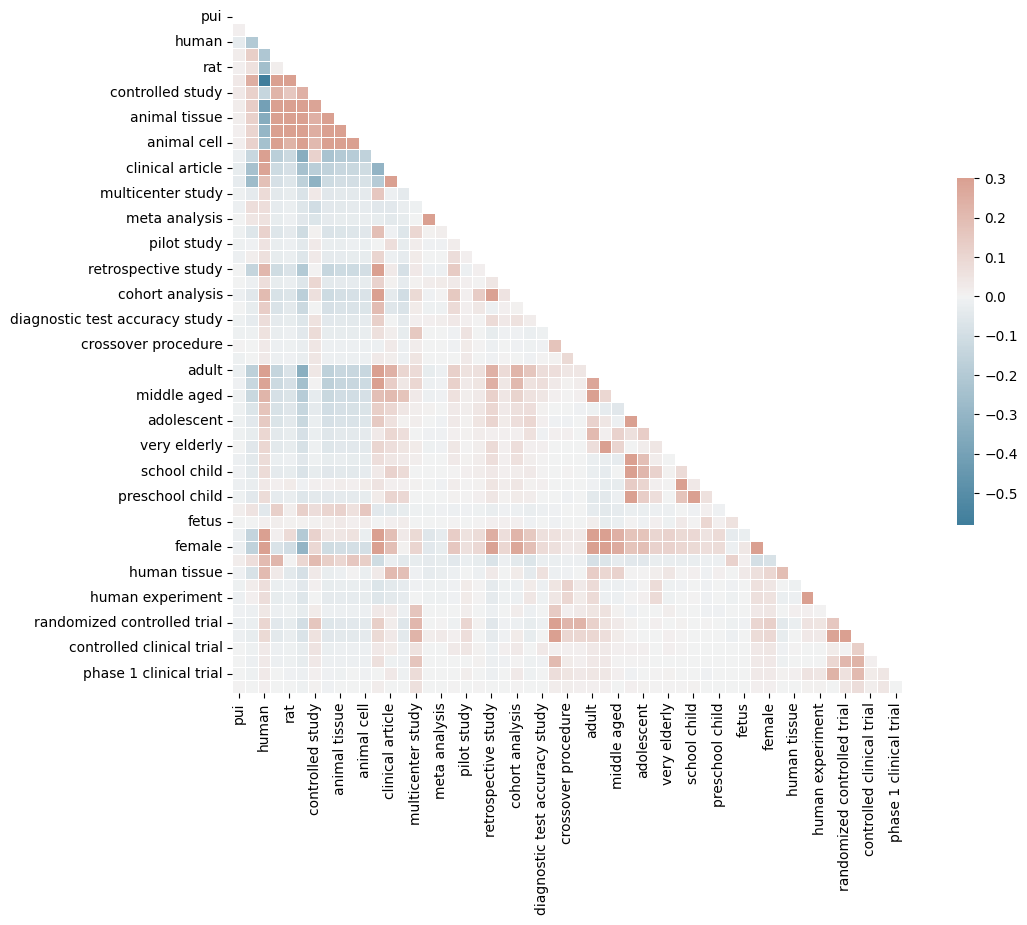

In [56]:
# inspect correlation between labels
corr = data_df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [57]:
def collect_pairs(lines, combination_size):
    """Count the co-occurrences of labels."""
    pair_counter = Counter()
    for line in lines:
        unique_tokens = sorted(set(line))  # exclude duplicates in same line and sort to ensure one word is always before other
        combos = combinations(unique_tokens, combination_size)
        pair_counter += Counter(combos)
    return pair_counter

In [58]:
# get all the label combinations
label_columns.loc[:, 'label'] = label_columns.apply(lambda row:get_labels(row[label_columns.columns]), axis=1)
all_label_combinations = label_columns['label'].to_list()

In [59]:
# the average number of labels:
print('This is the average number of labels: ', sum([len(l) for l in all_label_combinations])/len(all_label_combinations))
# print('The occurrence of each label: \n', label_columns.sum())

This is the average number of labels:  5.504725259333108


In [60]:
# check the 30 most occurring label combinations
pairs = collect_pairs(all_label_combinations, combination_size=5)
pairs.most_common(30)

KeyboardInterrupt: 

### Check the occurrence and co-occurrence of different author assigned keywords

In [61]:
# get the average number of keywords
keywords_df = \
    data_df['keywords'].\
    dropna().\
    str.replace('[^|\w\s]','', regex=True).\
    str.lower().\
    str.split('|')

keywords_np = keywords_df.to_numpy()

keywords_list_merged = list(itertools.chain.from_iterable(keywords_np))

print(f'The number of unique keywords: {len(np.unique(keywords_list_merged))}')
unique, counts = np.unique(keywords_list_merged, return_counts=True)
print("The most occurring keywords in the dataset: ", sorted(list(zip(unique, counts)), key=lambda x: x[1], reverse=True)[:100])

The number of unique keywords: 181875
The most occurring keywords in the dataset:  [('covid19', 4683), ('sarscov2', 1686), ('inflammation', 1249), ('prognosis', 1146), ('breast cancer', 1008), ('apoptosis', 974), ('obesity', 923), ('children', 914), ('epidemiology', 893), ('depression', 865), ('oxidative stress', 857), ('mortality', 855), ('case report', 779), ('pregnancy', 701), ('cancer', 680), ('quality of life', 678), ('coronavirus', 641), ('risk factors', 599), ('alzheimers disease', 593), ('stroke', 589), ('anxiety', 577), ('diabetes', 565), ('magnetic resonance imaging', 541), ('biomarker', 533), ('diagnosis', 519), ('biomarkers', 511), ('hepatocellular carcinoma', 510), ('pandemic', 496), ('colorectal cancer', 489), ('hypertension', 485), ('machine learning', 481), ('survival', 475), ('surgery', 472), ('treatment', 465), ('mental health', 461), ('metaanalysis', 448), ('immunotherapy', 444), ('heart failure', 440), ('autophagy', 425), ('diabetes mellitus', 416), ('parkinsons dis

### Check the author occurrences

In [62]:
# first create a pivotted table with the article and the authors individually in a second column
author_df = data_df[['pui', 'authors']]
author_df = author_df.explode('authors').reset_index(drop=True)
author_qs = pd.json_normalize(author_df['authors']).reset_index(drop=True)
author_df = pd.concat([author_df, author_qs], axis=1)

In [63]:
# look at the identifiable orcid ids and the occurrences there
print(f'The occurrences of orcid ids in the current dataset: \n', author_df["orcid"].value_counts()[:15])
print(f'The number of authors with only one article under their orcid: ', (author_df["orcid"].value_counts() == 1).sum())
print(f'The occurrences of index names (to see whether name matching would make sense, disclaimer it would not...): \n', author_df["indexed-name"].value_counts()[:20])
single_author_paper = author_df.drop_duplicates(subset=["instance-id", "author-id"])
print(f'The occurrences of authors ids in the current dataset: \n', single_author_paper['author-id'].value_counts()[:15])


The occurrences of orcid ids in the current dataset: 
 0000-0002-6124-7037    24
0000-0002-7189-1707    22
0000-0001-8200-6382    15
0000-0002-1917-5893    14
0000-0002-8995-7583    13
0000-0003-4656-7427    12
0000-0003-3701-8119    11
0000-0002-3652-6085    11
0000-0001-8020-019X    11
0000-0001-7307-2468    10
0000-0001-5411-1492    10
0000-0001-9550-9050    10
0000-0003-1776-9556    10
0000-0002-8502-7952    10
0000-0002-8656-1444    10
Name: orcid, dtype: int64
The number of authors with only one article under their orcid:  76899
The occurrences of index names (to see whether name matching would make sense, disclaimer it would not...): 
 Wang Y.     2451
Zhang Y.    2214
Li Y.       1962
Wang J.     1762
Liu Y.      1740
Wang X.     1716
Li J.       1540
Zhang X.    1521
Li X.       1465
Zhang J.    1462
Chen Y.     1283
Wang L.     1203
Liu J.      1202
Zhang L.    1166
Wang H.     1133
Liu X.      1128
Wang Z.     1071
Zhang H.    1034
Chen J.     1019
Li H.       1001
Name: ind

### Clean text data

In [64]:
from gensim.parsing.preprocessing import remove_stopwords


In [65]:
data_df['abstract'] = data_df['abstract'].fillna(data_df['abstract_2'])
text_df = data_df['abstract'].\
    dropna().\
    str.lower().\
    str.replace('[^|\w\s]','', regex=True).\
    apply(lambda x: remove_stopwords(x))

text_df


0         successful cognitive development childhood adu...
1         benzodiazepines bzds standard treatment anxiet...
2         bipolar disorder bd common mood disorder chara...
4         solidliquid extraction sle solvent different p...
5         background treatment individuals asymptomatic ...
                                ...                        
121364    introduction leiomyosarcoma rare mesenchymal t...
121365    introduction implantbased breast reconstructio...
121366    highway runoff impacts urban natural ecosystem...
121367    objectives remdesivir current recommended anti...
121368    background neuroendocrine tumors net rare tumo...
Name: abstract, Length: 117311, dtype: object

### Check the correlation of the labels with the keywords and the authors

In [78]:
most_common_keywords = sorted(list(zip(unique, counts)), key=lambda x: x[1], reverse=True)
most_common_keywords = [keyword[0] for keyword in most_common_keywords[:100]]
onehot_keyword_df = pd.DataFrame(columns=most_common_keywords, index=data_df.index)

for column in onehot_keyword_df.columns:
    onehot_keyword_df[column] = data_df['keywords'].str.contains(column)

covid19
0           NaN
1           NaN
2           NaN
3         False
4         False
          ...  
121364    False
121365    False
121366    False
121367    False
121368    False
Name: keywords, Length: 121369, dtype: object
sarscov2
0           NaN
1           NaN
2           NaN
3         False
4         False
          ...  
121364    False
121365    False
121366    False
121367    False
121368    False
Name: keywords, Length: 121369, dtype: object
inflammation
0           NaN
1           NaN
2           NaN
3         False
4         False
          ...  
121364    False
121365    False
121366    False
121367    False
121368    False
Name: keywords, Length: 121369, dtype: object
prognosis
0           NaN
1           NaN
2           NaN
3         False
4         False
          ...  
121364    False
121365    False
121366    False
121367    False
121368    False
Name: keywords, Length: 121369, dtype: object
breast cancer
0           NaN
1           NaN
2           NaN
3         

0           NaN
1           NaN
2           NaN
3         False
4         False
          ...  
121364    False
121365    False
121366    False
121367    False
121368    False
Name: keywords, Length: 121369, dtype: object
immunotherapy
0           NaN
1           NaN
2           NaN
3         False
4         False
          ...  
121364    False
121365    False
121366    False
121367    False
121368    False
Name: keywords, Length: 121369, dtype: object
heart failure
0           NaN
1           NaN
2           NaN
3         False
4         False
          ...  
121364    False
121365    False
121366    False
121367    False
121368    False
Name: keywords, Length: 121369, dtype: object
autophagy
0           NaN
1           NaN
2           NaN
3         False
4         False
          ...  
121364    False
121365    False
121366    False
121367    False
121368    False
Name: keywords, Length: 121369, dtype: object
diabetes mellitus
0           NaN
1           NaN
2           NaN
3       

0           NaN
1           NaN
2           NaN
3         False
4         False
          ...  
121364    False
121365    False
121366    False
121367    False
121368    False
Name: keywords, Length: 121369, dtype: object
antioxidant
0           NaN
1           NaN
2           NaN
3         False
4          True
          ...  
121364    False
121365    False
121366    False
121367    False
121368    False
Name: keywords, Length: 121369, dtype: object
safety
0           NaN
1           NaN
2           NaN
3         False
4         False
          ...  
121364    False
121365    False
121366    False
121367    False
121368    False
Name: keywords, Length: 121369, dtype: object
asthma
0           NaN
1           NaN
2           NaN
3         False
4         False
          ...  
121364    False
121365    False
121366    False
121367    False
121368    False
Name: keywords, Length: 121369, dtype: object
outcomes
0           NaN
1           NaN
2           NaN
3         False
4         Fal

In [93]:
keywords_labels = pd.concat([onehot_keyword_df.reset_index(drop=True), 
                             label_columns.reset_index(drop=True)], axis=1)
keywords_labels.fillna(0, inplace=True)
keywords_labels = keywords_labels.replace({True: 1, False: 0})


<Axes: >

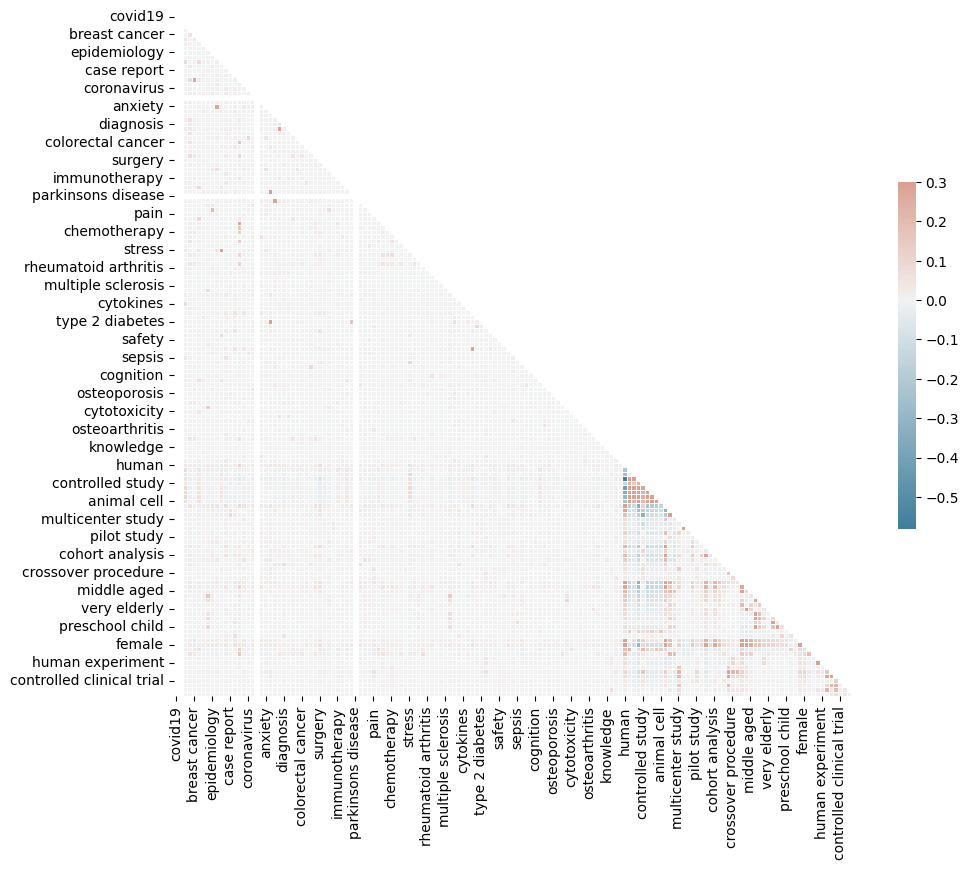

In [94]:
# inspect correlation between labels
keywords_labels_corr = keywords_labels.corr(numeric_only=True)

These are the strongest correlations: 
                  level_0       level_1         0
16       clinical article   case report  0.616459
111      controlled study   case report  0.321993
241  major clinical study   case report  0.193353
248          human tissue   case report  0.188567
265                 human   case report  0.181777
276                 child      children  0.171186
283           middle aged   case report  0.169389
301              nonhuman   case report  0.164841
306          human tissue        cancer  0.162980
333                 child     pediatric  0.148689
399            human cell        cancer  0.124623
423     animal experiment   case report  0.118139
463                 human        cancer  0.112748
477                  aged        cancer  0.110278
506          animal model  inflammation  0.103058
513                 adult   case report  0.102567
515       cohort analysis   case report  0.102457
525            adolescent   adolescents  0.101239
567        

<Axes: >

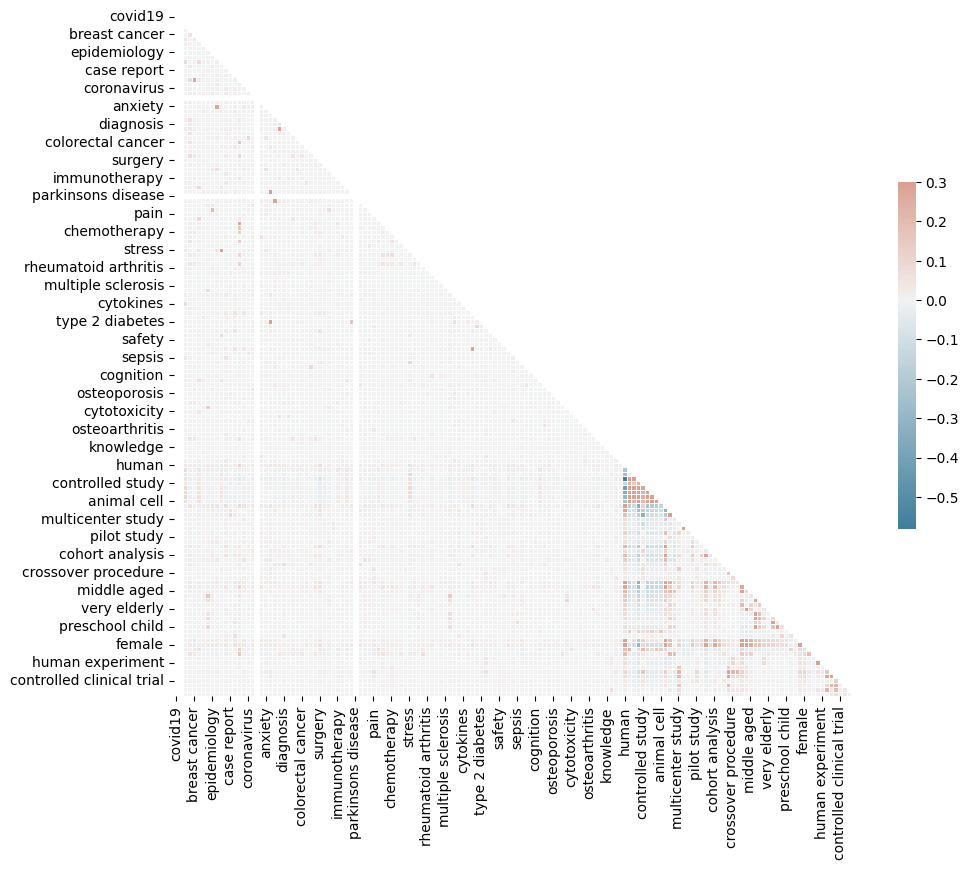

In [107]:
s = keywords_labels_corr.abs().unstack()
so = s.sort_values(kind="quicksort", ascending=False)

correlations = so.loc[(so != 1)].reset_index()
only_keywords_label_combinations = correlations.loc[(correlations['level_0'].isin(label_columns.columns)) & 
                                                    (correlations['level_1'].isin(onehot_keyword_df.columns))] 
print(f'These are the strongest correlations: \n{only_keywords_label_combinations[:25]}')
mask = np.triu(np.ones_like(keywords_labels_corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(keywords_labels_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Check the KNN capabilities for assigning multi-labels based on sematic similarity